In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFTGate  
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library.basis_change import QFT
from PIL import Image
import numpy as np


import sys
import os

sys.path.insert(0, os.path.abspath(".."))

from neqr import neqr
from ladder import ladder_up
from enhanced_grover import filter_oracle
from qsubtract import subtract
from qadd import qft_adder
from qedge import qedge




In [2]:
def load_image(filepath, size=(16, 16)):
    img = Image.open(filepath).convert('L')  # Grayscale
    img = img.resize(size, Image.Resampling.LANCZOS)
    img_array = np.array(img)
    return img_array

def normalize_image(image, bits=2):
    max_val = 2**bits - 1
    return np.round((image / 255) * max_val).astype(int)

image = load_image('../heartimg.png',size=(16,16))
image = normalize_image(image, bits=2)
print(image)

[[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [3 3 0 0 0 0 3 3 3 2 0 0 0 1 3 3]
 [3 1 1 1 1 1 0 3 2 0 1 1 1 1 1 3]
 [0 1 3 3 1 1 1 0 0 1 1 1 1 1 1 0]
 [0 1 2 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [3 1 1 1 1 1 1 1 1 1 1 1 1 0 1 3]
 [3 3 1 1 1 1 1 1 1 1 1 1 0 1 3 3]
 [3 3 3 1 1 1 1 1 1 1 1 0 1 3 3 3]
 [3 3 3 3 1 1 1 1 1 1 0 1 3 3 3 3]
 [3 3 3 3 3 1 0 1 1 0 1 3 3 3 3 3]
 [3 3 3 3 3 3 1 0 0 1 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 1 1 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]]


In [3]:
def split_image(image, tile_size):
    h, w = image.shape
    tiles = []
    for i in range(0, h, tile_size):
        for j in range(0, w, tile_size):
            tiles.append(image[i:i+tile_size, j:j+tile_size])
    return tiles


In [4]:
def counts_to_image(counts_items, intensity_bits, x_bits, y_bits):
    dim = 2 ** x_bits
    image = np.zeros((dim, dim), dtype=int)
    for bitstring, count in counts_items:
        bitstring = bitstring[::-1]  # Little-endian to MSB-first

        intensity = int(bitstring[:intensity_bits][::-1], 2)
        y = int(bitstring[intensity_bits:intensity_bits + y_bits][::-1], 2)
        x = int(bitstring[intensity_bits + y_bits:][::-1], 2)

        image[y, x] = intensity
    return image


In [5]:
def stitch_images(tile_outputs, image_shape, tile_size):
    output_image = np.zeros(image_shape, dtype=int)
    tiles_per_row = image_shape[1] // tile_size
    for idx, tile_img in enumerate(tile_outputs):
        i = (idx // tiles_per_row) * tile_size
        j = (idx % tiles_per_row) * tile_size
        output_image[i:i+tile_size, j:j+tile_size] = tile_img
    return output_image


3
[0, 0, 0]
2 0
max 2
1 0
0 0
3
[0, 0, 0]
2 0
max 2
1 0
0 0
3
[0, 0, 0]
2 0
max 2
1 0
0 0
3
[0, 0, 0]
2 0
max 2
1 0
0 0
3
[0, 0, 0]
2 0
max 2
1 0
0 0
3
[0, 0, 0]
2 0
max 2
1 0
0 0
3
[0, 0, 0]
2 0
max 2
1 0
0 0
3
[0, 0, 0]
2 0
max 2
1 0
0 0
3
[0, 0, 0]
2 0
max 2
1 0
0 0
3
[0, 0, 0]
2 0
max 2
1 0
0 0
3
[0, 0, 0]
2 0
max 2
1 0
0 0
3
[0, 0, 0]
2 0
max 2
1 0
0 0
3
[0, 0, 0]
2 0
max 2
1 0
0 0
3
[0, 0, 0]
2 0
max 2
1 0
0 0
3
[0, 0, 0]
2 0
max 2
1 0
0 0
3
[0, 0, 0]
2 0
max 2
1 0
0 0


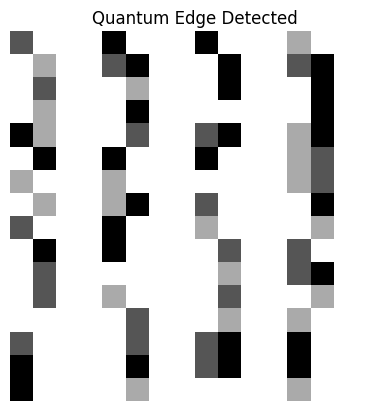

In [6]:
big_image = image  # load from file or generate
tile_size = 4
intensity_bits = 2
x_bits = y_bits = int(np.log2(tile_size))

all_counts = []
tiles = split_image(big_image, tile_size)
for tile in tiles:
    counts = qedge(tile)
    all_counts.append(counts)

images = [counts_to_image(c, intensity_bits, x_bits, y_bits) for c in all_counts]
output = stitch_images(images, big_image.shape, tile_size)

# View result
import matplotlib.pyplot as plt
plt.imshow(1 - output / output.max(), cmap='gray')  # invert grayscale
plt.title("Quantum Edge Detected")
plt.axis('off')
plt.show()